In [45]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f

# import files_management

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'%.2f'

In [46]:
img_left = cv2.imread('frame_00077_1547042741L.png')
img_right = cv2.imread('frame_00077_1547042741R.png')
if img_left is None or img_right is None:
    print("Error loading images!")
else:
    print("Images loaded successfully")

Images loaded successfully


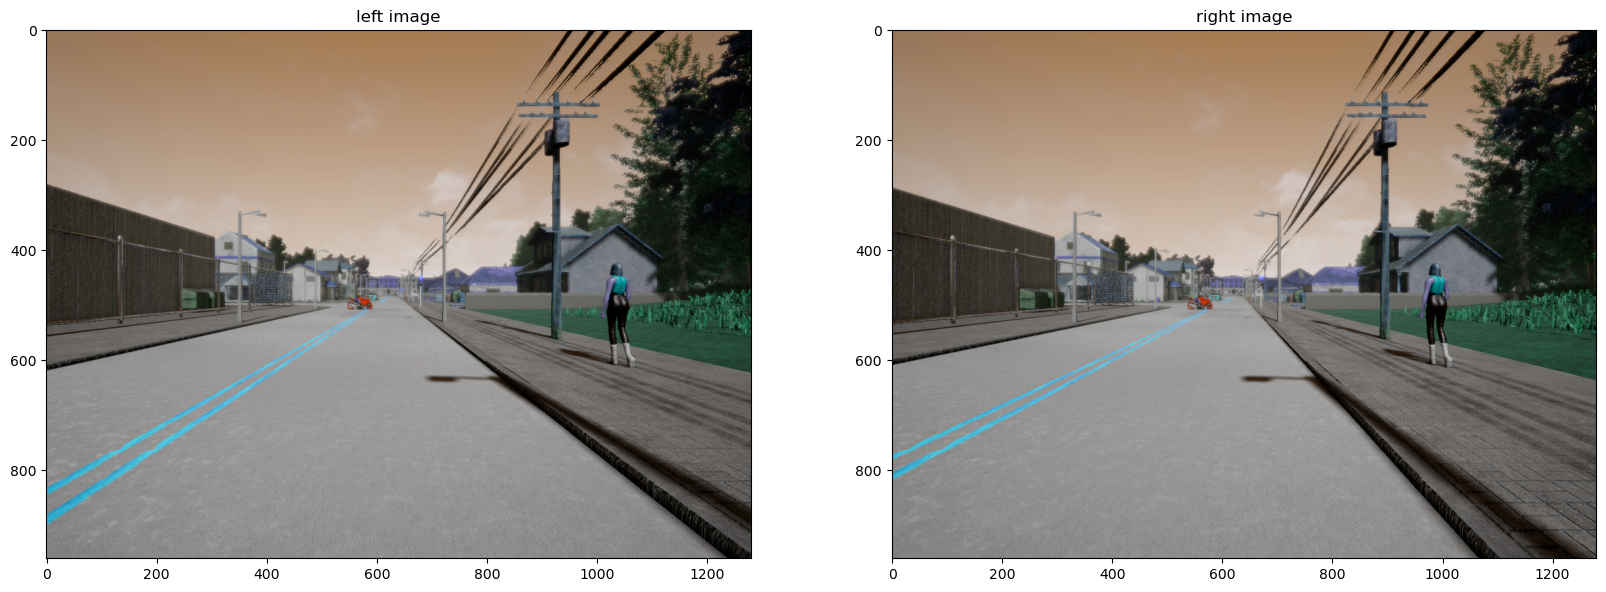

In [47]:
# Use matplotlib to display the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right)
image_cells[1].set_title('right image')
plt.show()

In [30]:
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(img_left)

In [48]:
def get_projection_matrices():
    """Frame Calibration Holder
    3x4    p_left, p_right      Camera P matrix. Contains extrinsic and intrinsic parameters.
    """
    p_left = np.array([[640.0,   0.0, 640.0, 2176.0], 
                       [  0.0, 480.0, 480.0,  552.0], 
                       [  0.0,   0.0,   1.0,    1.4]])
    p_right = np.array([[640.0,   0.0, 640.0, 2176.0], 
                       [   0.0, 480.0, 480.0,  792.0], 
                       [   0.0,   0.0,   1.0,    1.4]])
    return p_left, p_right 

In [49]:
# Read the calibration
p_left, p_right = get_projection_matrices()

# Use regular numpy notation instead of scientific one 
np.set_printoptions(suppress=True)

print("p_left \n", p_left)
print("\np_right \n", p_right)

p_left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

p_right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


In [50]:
def compute_left_disparity_map(img_left, img_right):
    
    ### START CODE HERE ###
    
    # Parameters
    num_disparities = 6*16
    block_size = 11
    
    min_disparity = 0
    window_size = 6
    
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    
    # Stereo BM matcher
    left_matcher_BM = cv2.StereoBM_create(
        numDisparities=num_disparities,
        blockSize=block_size
    )

    # Stereo SGBM matcher
    left_matcher_SGBM = cv2.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute the left disparity map
    disp_left = left_matcher_SGBM.compute(img_left, img_right).astype(np.float32)/16
    
    ### END CODE HERE ###
    
    return disp_left

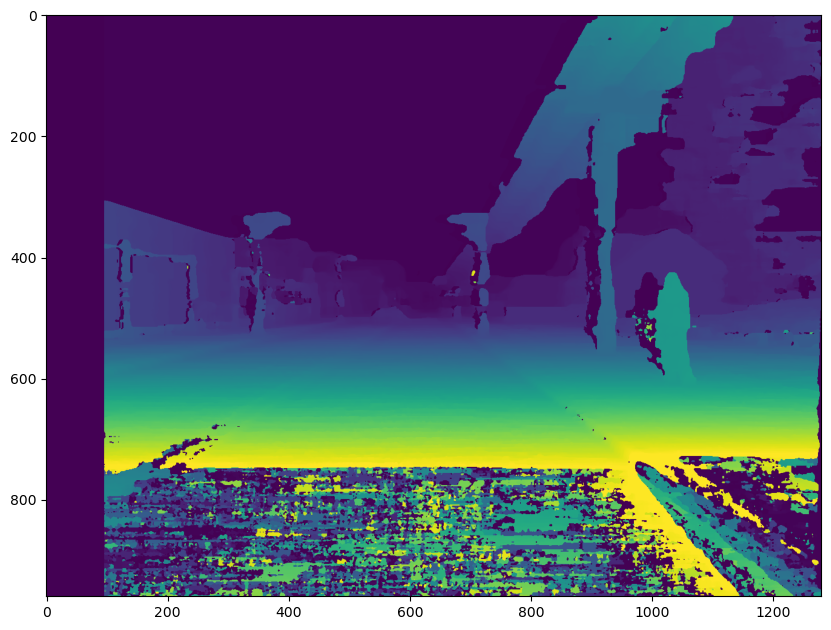

In [51]:
# Compute the disparity map using the fuction above
disp_left = compute_left_disparity_map(img_left, img_right)

# Show the left disparity map
plt.figure(figsize=(10, 10))
plt.imshow(disp_left)
plt.show()

In [52]:
def decompose_projection_matrix(p):
    
    ### START CODE HERE ###
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3]
    
    ### END CODE HERE ###
    
    return k, r, t

In [53]:
# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

k_right 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


In [54]:
def calc_depth_map(disp_left, k_left, t_left, t_right):

    ### START CODE HERE ###
    
    # Get the focal length from the K matrix
    f = k_left[0, 0]

    # Get the distance between the cameras from the t matrices (baseline)
    b = t_left[1] - t_right[1]

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1

    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)

    # Calculate the depths 
    depth_map[:] = f * b / disp_left[:]
    
    ### END CODE HERE ###
    
    return depth_map

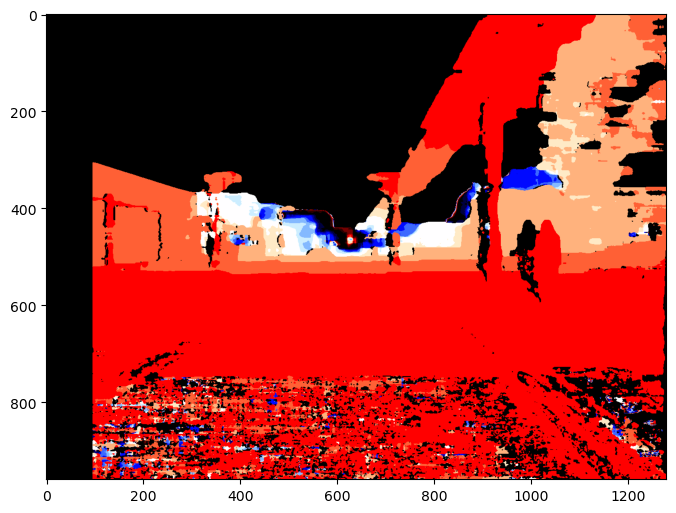

In [55]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

In [56]:
def locate_obstacle_in_image(image, obstacle_image):
    
    ### START CODE HERE ###
    
    # Run the template matching from OpenCV
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method=cv2.TM_CCOEFF)
    
    # Locate the position of the obstacle using the minMaxLoc function from OpenCV
    _, _, _, obstacle_location = cv2.minMaxLoc(cross_corr_map)

    ### END CODE HERE ###

    return cross_corr_map, obstacle_location

In [57]:
def get_obstacle_image():
    img_left_colour = cv2.imread('frame_00077_1547042741L.png')
    return img_left_colour[479:509, 547:593, :]

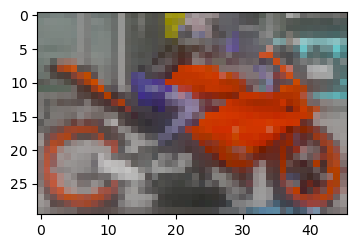

In [58]:
obstacle_image = get_obstacle_image()

# Show the obstacle image
plt.figure(figsize=(4, 4))
plt.imshow(obstacle_image)
plt.show()

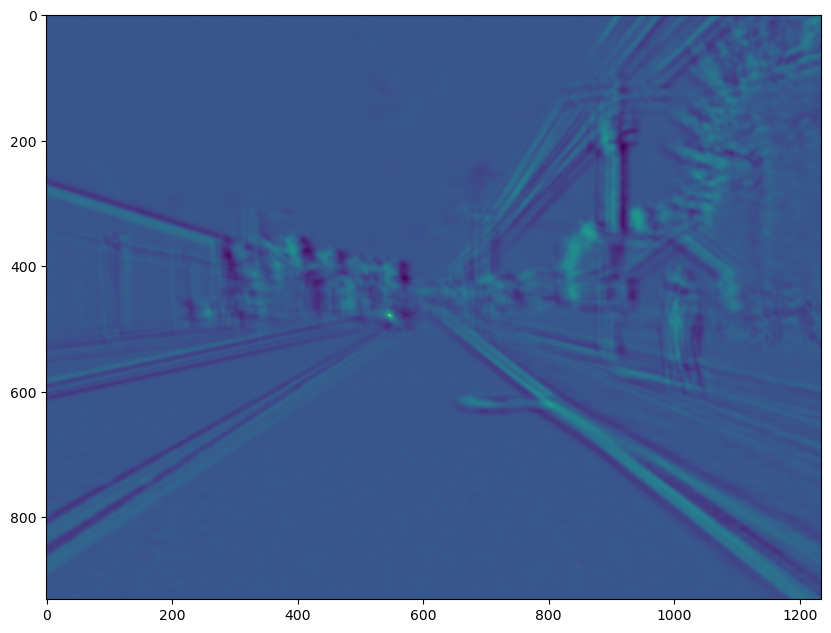

obstacle_location 
 (547, 479)


In [59]:
# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

# Print the obstacle location
print("obstacle_location \n", obstacle_location)

In [60]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
    
    ### START CODE HERE ###
    
    # Gather the relative parameters of the obstacle box
    obstacle_width = obstacle_img.shape[0]
    obstacle_height = obstacle_img.shape[1]
    obstacle_min_x_pos = obstacle_location[1]
    obstacle_max_x_pos = obstacle_location[1] + obstacle_width
    obstacle_min_y_pos = obstacle_location[0]
    obstacle_max_y_pos = obstacle_location[0] + obstacle_height

    # Get the depth of the pixels within the bounds of the obstacle image, find the closest point in this rectangle
    obstacle_depth = depth_map_left[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()

    ### END CODE HERE ###
    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_y_pos, obstacle_min_x_pos), obstacle_height, obstacle_width, 
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

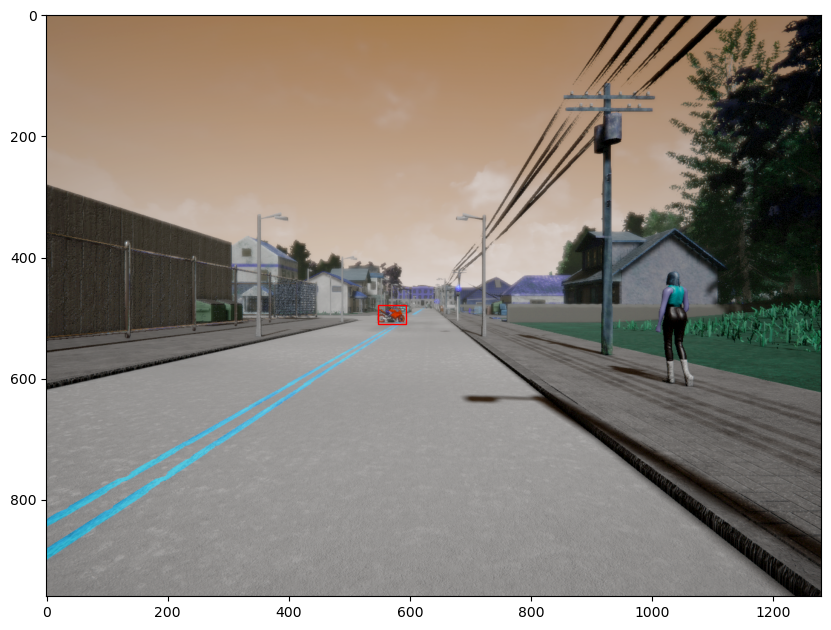

closest_point_depth 28.444


In [61]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_left)
ax.add_patch(obstacle_bbox)
plt.show()

# Print the depth of the nearest point
print("closest_point_depth {0:0.3f}".format(closest_point_depth))

In [64]:

p_left, p_right = get_projection_matrices()


# Part 2. Estimating Depth
disp_left = compute_left_disparity_map(img_left, img_right)
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)


# Part 3. Finding the distance to collision
obstacle_image = get_obstacle_image()
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)


# Print Result Output
print("Left Projection Matrix Decomposition:\n {0}".format([k_left.tolist(), 
                                                            r_left.tolist(), 
                                                            t_left.tolist()]))
print("\nRight Projection Matrix Decomposition:\n {0}".format([k_right.tolist(), 
                                                               r_right.tolist(), 
                                                               t_right.tolist()]))
print("\nObstacle Location (left-top corner coordinates):\n {0}".format(list(obstacle_location)))
print("\nClosest point depth (meters):\n {0}".format(closest_point_depth))

Left Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [0.24999999999999944], [-1.3999999999999997], [1.0]]]

Right Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [-0.25000000000000006], [-1.4], [1.0]]]

Obstacle Location (left-top corner coordinates):
 [547, 479]

Closest point depth (meters):
 28.44444465637207
